#Installations & Imports

In [1]:
#!pip install pytorch-lightning

In [2]:
import torch
import torchvision
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.datasetloader import DatasetLoader

#Parameter Initialization

In [3]:
import os
# Insert your own path here
ds_path = os.path.join(".", "data/")

variation = "B-VAE" #B-VAE, VAE

configuration = {
    "dataset": "c24s", #c24,c24s,NYU,MNIST, CIFAR10
    "path": ds_path
}

architecture = {
    "conv_layers": 3,
    "conv_channels": [128, 256, 512],
    "conv_kernel_sizes": [(7, 7), (7, 7), (5, 5)],
    "conv_strides": [(2, 2), (2, 2), (1, 1)],
    "conv_paddings": [(1, 1), (1, 1), (1, 1)],
    "z_dimension": 64
}

hyperparameters = {
    "epochs": 10,
    "batch_size": 1,
    "learning_rate": 3e-6,
    "beta": 150
}

In [4]:
def prepare_dataset(configuration):
    """
    :param dict configuration: The configuration dictionary returned by parse_config_file

    :return:        A dictionary containing information about the dataset used

    Function used to set some values used by the model based on the dataset selected
    """
    dataset_info = {}
    if (configuration["dataset"] == "MNIST"):
        dataset_info["ds_method"] = torchvision.datasets.MNIST
        dataset_info["ds_shape"] = (1, 28, 28)
        dataset_info["ds_path"] = configuration["path"]
    elif (configuration["dataset"] == "CIFAR10"):
        dataset_info["ds_method"] = torchvision.datasets.CIFAR10
        dataset_info["ds_shape"] = (3, 32, 32)
        dataset_info["ds_path"] = configuration["path"]
    elif (configuration["dataset"] == "FashionMNIST"):
        dataset_info["ds_method"] = torchvision.datasets.FashionMNIST
        dataset_info["ds_shape"] = (1, 28, 28)
        dataset_info["ds_path"] = configuration["path"]
    elif (configuration["dataset"] == "NYU"):
        dataset_info["ds_method"] = DatasetLoader
        dataset_info["ds_shape"] = (1, 480, 640)
        dataset_info["ds_path"] = configuration["path"]+"NYU/"
    elif (configuration["dataset"] == "c24s"):
        dataset_info["ds_method"] = DatasetLoader
        dataset_info["ds_shape"] = (1, 480, 640)
        dataset_info["ds_path"] = configuration["path"]+"c24s/"
    elif (configuration["dataset"] == "c24"):
        dataset_info["ds_method"] = DatasetLoader
        dataset_info["ds_shape"] = (1, 360, 640)
        dataset_info["ds_path"] = configuration["path"]+"c24/"
    else:
        print("Currently only MNIST & CIFAR10 datasets are supported")
        return None

    return dataset_info

In [5]:
dataset_info = prepare_dataset(configuration)

#Model Declaration

#####Utility Functions

In [6]:
from torch import nn
def compute_output_shape(current_shape, kernel_size, stride, padding):
    """
    :param tuple current_shape:  The current shape of the data before a convolution is applied.
    :param tuple kernel_size:    The kernel size of the current convolution operation.
    :param tuple stride:         The stride of the current convolution operation.
    :param tuple padding:        The padding of the current convolution operation.

    :return:  The shape after a convolution operation with the above parameters is applied.
    :rtype:   tuple

            The formula used to compute the final shape is

        component[i] = floor((N[i] - K[i] + 2 * P[i]) / S[i]) + 1

        where, N = current shape of the data
               K = kernel size
               P = padding
               S = stride
    """
    # get the dimension of the data compute each component using the above formula
    dimensions = len(current_shape)
    return tuple((current_shape[i] - kernel_size[i] + 2 * padding[i]) // stride[i] + 1
                 for i in range(dimensions))


def compute_transpose_output_shape(current_shape, kernel_size, stride, padding):
    """
    :param tuple current_shape:  The current shape of the data before a transpose convolution is
                                   applied.
    :param tuple kernel_size:    The kernel size of the current transpose convolution operation.
    :param tuple stride:         The stride of the current transpose convolution operation.
    :param tuple padding:        The padding of the current transpose convolution operation.

    :return:  The shape after a transpose convolution operation with the above parameters is
                applied.
    :rtype:   tuple

            The formula used to compute the final shape is

        component[i] = (N[i] - 1) * S[i] - 2 * P[i] + (K[i] - 1) + 1

        where, N = current shape of the data
               K = kernel size
               P = padding
               S = stride
    """
    # get the dimension of the data compute each component using the above formula
    dimensions = len(current_shape)
    return tuple((current_shape[i] - 1) * stride[i] - 2 * padding[i] + (kernel_size[i] - 1) + 1
                 for i in range(dimensions))


def compute_output_padding(current_shape, target_shape):
    """
    :param tuple current_shape:  The shape of the data after a transpose convolution operation
                                   takes place.
    :param tuple target_shape:   The target shape that we would like our data to have after the
                                   transpose convolution operation takes place.

    :return:  The output padding needed so that the shape of the image after a transpose
                convolution is applied, is the same as the target shape.
    :rtype:   tuple
    """
    # basically subtract each term to get the difference which will be the output padding
    dimensions = len(current_shape)
    return tuple(target_shape[i] - current_shape[i] for i in range(dimensions))


def invalid_shape(current_shape):
    """
    :param tuple current_shape:  The current shape of the data after a convolution is applied.

    :return:  True if the shape is invalid, that is, a negative or 0 components exists. Else, it
                returns False.
    :rtype:   bool
    """
    # check all components
    for component in current_shape:
        if component <= 0:
            return True
    # return False if they are ok
    return False


def create_encoder(architecture, input_shape):
    """
    :param dict architecture:  A dictionary containing the hyperparameters that define the
                                 architecture of the model.
    :param tuple input_shape:  A tuple that corresponds to the shape of the input.

    :return:  A PyTorch Sequential model that represents the encoder part of a VAE, along with the
                final shape that a data point would have after the sequential is applied to it.
    :rtype:   (torch.nn.Sequential, tuple)

    This method builds the encoder part of a VAE and returns it. It is common for all types of VAE.
    """

    # initialize useful variables
    in_channels = input_shape[0]
    current_shape = (input_shape[1], input_shape[2])

    # initialize a list that will store the shape produced in each layer
    shape_per_layer = [current_shape]

    # build the encoder part
    conv_sets = []

    # iterate through the lists that define the architecture of the encoder
    for layer in range(architecture["conv_layers"]):

        # get the variables from the dictionary for more verbose
        out_channels = architecture["conv_channels"][layer]
        kernel_size = architecture["conv_kernel_sizes"][layer]
        stride = architecture["conv_strides"][layer]
        padding = architecture["conv_paddings"][layer]

        # add a set of Convolutional - Leaky ReLU - Batch Normalization sequential layers
        conv_sets.append(
            nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding),
                nn.LeakyReLU(negative_slope=0.15),
                nn.BatchNorm2d(out_channels))
        )

        # compute the new shape of the image
        current_shape = compute_output_shape(current_shape=current_shape,
                                             kernel_size=kernel_size,
                                             stride=stride,
                                             padding=padding)
        shape_per_layer.append(current_shape)

        # make sure that the shape is valid, and if not, raise an error
        if invalid_shape(current_shape):
            raise InvalidArchitectureError(shape=current_shape, layer=layer+1)

        # the output channels of the current layer becomes the input channels of the next layer
        in_channels = out_channels

    # create a Sequential model and return it (* asterisk is used to unpack the list)
    return nn.Sequential(*conv_sets), shape_per_layer


def create_decoder(architecture, encoder_shapes):
    """
    :param dict architecture:    A dictionary containing the hyperparameters that define the
                                   architecture of the model.
    :param list encoder_shapes:  A list that contains the shape of the data after it is applied to
                                    every set of convolutional layers.

    :return:  A PyTorch Sequential model that represents the decoder part of a VAE.
    :rtype:   (torch.nn.Sequential)

    This method builds the decoder part of a VAE and returns it. It is common for all types of VAE.
    """
    # now start building the decoder part
    conv_sets = []

    # initialize useful variables
    in_channels = architecture["conv_channels"][-1]

    # iterate through the lists that define the architecture of the decoder
    for layer in range(architecture["conv_layers"] - 1, -1, -1):

        # get the variables from the dictionary for more verbose
        out_channels = architecture["conv_channels"][layer]
        kernel_size = architecture["conv_kernel_sizes"][layer]
        stride = architecture["conv_strides"][layer]
        padding = architecture["conv_paddings"][layer]

        # compute the output shape after a transpose convolution in order to get the output padding
        current_shape = encoder_shapes[layer + 1]
        target_shape = encoder_shapes[layer]
        output_shape = compute_transpose_output_shape(current_shape=current_shape,
                                                      kernel_size=kernel_size,
                                                      stride=stride,
                                                      padding=padding)
        output_padding = compute_output_padding(output_shape, target_shape)

        # add a set of ConvolutionalTranspose - Leaky ReLU - Batch Normalization sequential layers
        conv_sets.append(
            nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels,
                                   out_channels=out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   output_padding=output_padding),
                nn.LeakyReLU(negative_slope=0.15),
                nn.BatchNorm2d(out_channels))
        )

        # the output channels of the current layer becomes the input channels of the next layer
        in_channels = out_channels

    # create a Sequential model and return it (* asterisk is used to unpack the list)
    return nn.Sequential(*conv_sets)


def create_output_layer(architecture, input_shape):
    """
    :param dict architecture:  A dictionary containing the hyperparameters that define the
                                 architecture of the model.
    :param tuple input_shape:  A tuple that corresponds to the shape of the input.

    :return:  A PyTorch Sequential model that represents the output layer of a VAE.
    :rtype:   torch.nn.Sequential

    This method creates the output layer of a VAE, that is, the layer where the data from the
    output of the decoder gets fed in order to be finally reconstructed.
    """
    # define the variables of the architecture for more verbose
    in_channels = architecture["conv_channels"][0]
    kernel_size = architecture["conv_kernel_sizes"][0]
    stride = architecture["conv_strides"][0]
    padding = architecture["conv_paddings"][0]

    return nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels,
                                            out_channels=in_channels,
                                            kernel_size=kernel_size,
                                            stride=stride,
                                            padding=padding),
                         nn.SELU(),
                         nn.BatchNorm2d(in_channels),
                         nn.Conv2d(in_channels=in_channels,
                                   out_channels=input_shape[0],
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding),
                         nn.Sigmoid())

###Variational Auto-Encoder

In [7]:
import multiprocessing

class VAE(pl.LightningModule):
    """ Class that implements a Variational Autoencoder """

    def __init__(self, architecture, hyperparameters, dataset_info):
        """
        :param dict architecture:      A dictionary containing the hyperparameters that define the
                                         architecture of the model.
        :param dict hyperparameters:   A tuple that corresponds to the shape of the input.
        :param dict dataset_info:      The dimension of the latent vector z (bottleneck).

        The constructor of the Variational Autoencoder.
        """

        # call the constructor of the super class
        super(VAE, self).__init__()

        # initialize class variables regarding the architecture of the model
        self.conv_layers = architecture["conv_layers"]
        self.conv_channels = architecture["conv_channels"]
        self.conv_kernel_sizes = architecture["conv_kernel_sizes"]
        self.conv_strides = architecture["conv_strides"]
        self.conv_paddings = architecture["conv_paddings"]
        self.z_dim = architecture["z_dimension"]

        # unpack the "hyperparameters" dictionary
        self.batch_size = hyperparameters["batch_size"]
        self.learning_rate = hyperparameters["learning_rate"]
        self.scheduler_step_size = hyperparameters["epochs"] // 2

        # unpack the "dataset_info" dictionary
        self.dataset_method = dataset_info["ds_method"]
        self.dataset_shape = dataset_info["ds_shape"]
        self.dataset_path = dataset_info["ds_path"]

        # build the encoder
        self.encoder, self.encoder_shapes = create_encoder(architecture, self.dataset_shape)

        # compute the length of the output of the decoder once it has been flattened
        in_features = self.conv_channels[-1] * np.prod(self.encoder_shapes[-1][:])
        # now define the mean and standard deviation layers
        self.mean_layer = nn.Linear(in_features=in_features, out_features=self.z_dim)
        self.std_layer = nn.Linear(in_features=in_features, out_features=self.z_dim)
        # use a linear layer for the input of the decoder
        in_channels = self.conv_channels[-1]
        self.decoder_input = nn.Linear(in_features=self.z_dim, out_features=in_features)

        # build the decoder
        self.decoder = create_decoder(architecture, self.encoder_shapes)
 
        # build the output layer
        self.output_layer = create_output_layer(architecture, self.dataset_shape)

    def _encode(self, X):
        """
        :param Tensor X:  Input to encode into mean and standard deviation. (N, C, H, W)

        :return:  The mean and std tensors that the encoder produces for input X. (N, z_dim)
        :rtype:   (Tensor, Tensor)

        This method applies forward propagation to the self.encoder in order to get the mean and
        standard deviation of the latent vector z.
        """
        # run the input through the encoder part of the Network
        encoded_input = self.encoder(X)
        # flatten so that it can be fed to the mean and standard deviation layers
        encoded_input = torch.flatten(encoded_input, start_dim=1)
        # compute the mean and standard deviation
        mean = self.mean_layer(encoded_input)

        std = self.std_layer(encoded_input)

        return mean, std

    def _compute_latent_vector(self, mean, std):
        """
        :param Tensor mean:  The mean of the latent vector z following a Gaussian distribution.
                               (N, z_dim)
        :param Tensor std:   The standard deviation of the latent vector z following a Gaussian
                               distribution. (N, z_dim)

        :return:  The Linear combination of the mean and standard deviation, where the latter
                    factor is multiplied with a random variable epsilon ~ N(0, 1). Basically
                    the latent vector z. (N, z_dim)
        :rtype:   Tensor

        This method computes the latent vector z by applying the reparameterization trick to the
        output of the mean and standard deviation layers, in order to be able to later compute the
        gradient. The stochasticiy here is introduced by the factor epsilon, which is an independent
        node. Thus, we do not have to compute its gradient during backpropagation.
        """

        # compute the stochastic node epsilon
        epsilon = torch.randn_like(std)

        # compute the linear combination of the above attributes and return
        return mean + epsilon * (1.0 / 2) * std

    def _decode(self, z):
        """
        :param Tensor z:  Latent vector computed using the mean and variance layers (with the
                            reparameterization trick). (N, z_dim)

        :return:  The output of the decoder part of the network. (N, C, H, W)
        :rtype:   Tensor

        This method performs forward propagation of the latent vector through the decoder of the
        VAE to get the final output of the network.
        """
        # run the latent vector through the "input decoder" layer

        decoder_input = self.decoder_input(z)

        # convert back the shape that will be fed to the decoder
        height = self.encoder_shapes[-1][0]
        width = self.encoder_shapes[-1][1]
        decoder_input = decoder_input.view(-1, self.conv_channels[-1], height, width)

        # run through the decoder
        decoder_output = self.decoder(decoder_input)

        # run through the output layer and return
        network_output = self.output_layer(decoder_output)

        return network_output

    def forward(self, X):
        """
        :param Tensor X:  The input to run through the VAE. (N, C, H, W)

        :return: The output of the Network, along with the mean, standard deviation layers.
                   (N, C, H, W), (N, z_dim), (N, z_dim)
        :rtype:  (Tensor, Tensor, Tensor)

        This method performs Forward Propagation through all the layers of the VAE and returns
        the reconstructed input.
        """
        # encode the input to get mean and standard deviation
        mean, std = self._encode(X)

        # get the latent vector z by using the reparameterization trick
        z = self._compute_latent_vector(mean, std)

        # compute the output by propagating the latent vector through the decoder and return
        decoded_output = self._decode(z)
        return decoded_output, mean, std

    def configure_optimizers(self):
        """
        :return:  The optimizer that will be used during backpropagation, along with a scheduler.
        :rtype:   (torch.optim.Optimizer, torch.optim.lr_scheduler)
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.scheduler_step_size,
                                                    gamma=0.1)

        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        """
        :param Tensor batch:   The current batch of the training set.
        :param int batch_idx:  The batch index of the current batch.

        :return:  A dictionary of the losses computed on the current prediction.
        :rtype:   (dict)
        """
        # unpack the current batch
        X, y = batch

        # pass it through the model
        X_hat, mean, std = self(X)
        # calculate the losses
        losses = VAE.criterion(X, X_hat, mean, std)

        return losses

    def train_dataloader(self):
        """
        :return:  A DataLoader object of the training set.
        :rtype:   torch.utils.data.DataLoader
        """
        # download the training set using torchvision if it hasn't already been downloaded
        train_set = self.dataset_method(root=self.dataset_path, train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
        # initialize a pytorch DataLoader to feed training batches into the model
        self.train_loader = DataLoader(dataset=train_set, batch_size=self.batch_size, shuffle=True,
                                       num_workers=multiprocessing.cpu_count()//2)
        return self.train_loader

    def test_step(self, batch, batch_idx):
        """
        :param Tensor batch:   The current batch of the test set.
        :param int batch_idx:  The batch index of the current batch.

        :return:  A tuple consisting of a dictionary of the losses computed on the current
                    prediction and the MSE Loss compared to the original picture.
        :rtype:  (dict, Tensor)
        """
        # unpack the current batch
        X, y = batch

        # pass it through the model
        X_hat, mean, std = self(X)
        # calculate the losses
        losses = VAE.criterion(X, X_hat, mean, std)

        # also calculate the MSE loss
        mse_loss_func = torch.nn.MSELoss()
        mse_loss = mse_loss_func(X, X_hat)

        self.log('mse_loss', mse_loss.item())
        self.log('losses', losses)
        return losses, mse_loss

    def test_dataloader(self):
        """
        :return:  A DataLoader object of the test set.
        :rtype:   torch.utils.data.DataLoader
        """
        # download the test set using torchvision if it is not already downloaded
        test_set = self.dataset_method(root=self.dataset_path, train=False, download=True,
                                       transform=torchvision.transforms.ToTensor())
        # initialize a pytorch DataLoader to feed test batches into the model
        self.test_loader = DataLoader(dataset=test_set, batch_size=self.batch_size, shuffle=True,
                                      num_workers=multiprocessing.cpu_count() // 2)
        return self.test_loader

    def sample(self, n):
        """
        :param int n: The amount of images

        :return:  None

        This method plots n sampled images next to each other
        """
        # create a new latent vector consisting of random values
        z = torch.randn(n, self.z_dim)

        # pass the vector through the decoder
        samples = self._decode(z)

        # set the correct colourmap that corresponds to the image dimension
        cmap = None
        if (self.dataset_shape[0] == 3):
            cmap = 'viridis'
        elif (self.dataset_shape[0] == 1):
            cmap = 'gray'

#         plot_multiple(samples.detach().numpy(), n, self.dataset_shape, cmap)
        plot_depth(samples.detach().numpy())
        plot_pcd(samples.detach().numpy())

    def reconstruct(self, n):
        """
        :param int n:  The number of images to plot in each row of whole plot.

        :return:  None

        This method plots n^2 reconstructed (from the test set) images next to each other.
        """

        # get as many batches from the test set to fill the final plot
        tensors = []
        img_count = 0
        self.test_loader = self.test_dataloader()
        while n > img_count:
            batch, y = next(iter(self.test_loader))
            img_count += len(batch)
            tensors.append(batch)

        # concatenate them
        X = torch.cat(tensors, dim=0)

        # pass them through the model
        X_hat, mean, std = self(X)
        min_imgs = min(n, len(X))

        # set the correct colourmap that corresponds to the image dimension
        cmap = None
        if (self.dataset_shape[0] == 3):
            cmap = 'viridis'
        elif (self.dataset_shape[0] == 1):
            cmap = 'gray'

        # plot the images and their reconstructions
#         plot_multiple(X_hat.detach().numpy(), min_imgs, self.dataset_shape, cmap)
        plot_depth(X_hat.detach().numpy())
        plot_pcd(X_hat.detach().numpy())

    @staticmethod
    def _data_fidelity_loss(X, X_hat, eps=1e-10):
        """
        :param Tensor X:      The original input data that was passed to the VAE.
                                (N, C, H, W)
        :param Tensor X_hat:  The reconstructed data, the output of the VAE.
                                (N, C, H, W)
        :param Double eps:    A small positive double used to ensure we don't get log of 0.

        :return:  A tensor containing the Data Fidelity term of the loss function,
                    which is given by the formula below.
        :rtype:   Tensor

        E_{z ~ q_{phi}(z | x)}[log(p_{theta}(x|z))] = sum(x * log(x_hat) + (1 - x) * log(1 - x_hat))

            which is basically a Cross Entropy Loss.

        This method computes the Data Fidelity term of the loss function. A small positive double
        epsilon is added inside the logarithm to make sure that we don't get log(0).
        """
        # compute the data fidelity for every training example
        data_fidelity = torch.sum(X * torch.log(eps + X_hat) + (1 - X) * torch.log(eps + 1 - X_hat),
                                  axis=[1, 2, 3])
        return data_fidelity

    @staticmethod
    def _kl_divergence_loss(mean, std):
        """
        :param Tensor mean:  The output of the mean layer, computed with the output of the
                               encoder. (N, z_dim)
        :param Tensor std:   The output of the standard deviation layer, computed with the output
                               of the encoder. (N, z_dim)

        :return:  A tensor consisting of the KL-Divergence term of the loss function, which is
                    given by the formula below.
        :rtype:   Tensor

        D_{KL}[q_{phi}(z | x) || p_{theta}(x)] = (1/2) * sum(std + mean^2 - 1 - log(std))

            In the above equation we substitute std with e^{std} to improve numerical stability.

        This method computes the KL-Divergence term of the loss function. It substitutes the
        value of the standard deviation layer with exp(standard deviation) in order to ensure
        numerical stability.
        """
        # compute the kl divergence for each training example and return it
        kl_divergence = (1 / 2) * torch.sum(torch.exp(std) + torch.square(mean) - 1 - std, axis=1)
        return kl_divergence

    @staticmethod
    def criterion(X, X_hat, mean, std):
        """
        :param Tensor X:      The original input data that was passed to the VAE.
                                (N, C, H, W)
        :param Tensor X_hat:  The reconstructed data, the output of the VAE.
                                (N, C, H, W)
        :param Tensor mean:   The output of the mean layer, computed with the output of the
                                encoder. (N, z_dim)
        :param Tensor std:    The output of the standard deviation layer, computed with the output
                                of the encoder. (N, z_dim)

        :return: A dictionary containing the values of the losses computed.
        :rtype:  dict

        This method computes the loss of the VAE using the formula:

            L(x, x_hat) = - E_{z ~ q_{phi}(z | x)}[log(p_{theta}(x|z))]
                          + D_{KL}[q_{phi}(z | x) || p_{theta}(x)]

        Intuitively, the expectation term is the Data Fidelity term, and the second term is a
        regularizer that makes sure the distribution of the encoder and the decoder stay close.
        """
        # get the 2 losses
        data_fidelity_loss = VAE._data_fidelity_loss(X, X_hat)
        kl_divergence_loss = VAE._kl_divergence_loss(mean, std)

        # add them to compute the loss for each training example in the mini batch
        loss = -data_fidelity_loss + kl_divergence_loss

        # place them all inside a dictionary and return it
        losses = {"data_fidelity": torch.mean(data_fidelity_loss),
                  "kl-divergence": torch.mean(kl_divergence_loss),
                  "loss": torch.mean(loss)}
        return losses

###B-VAE

In [8]:
class betaVAE(VAE):
    """
    Class that implements a Disentangled Variational Autoencoder (Beta VAE).
    This class inherits from the VAE class.
    """

    def __init__(self, architecture, hyperparameters, dataset_info):
        """
        :param dict architecture:     A dictionary containing the hyperparameters that define the
                                        architecture of the model.
        :param dict hyperparameters:  A tuple that corresponds to the shape of the input.
        :param dict dataset_info:     The dimension of the latent vector z (bottleneck).

        The constructor of the Disentangled Variational Autoencoder.
        """

        # invoke the constructor of the VAE class, as the architecture is the same
        super(betaVAE, self).__init__(architecture, hyperparameters, dataset_info)

        # store the value of beta in the class as it exists only in this VAE variation
        self.beta = hyperparameters["beta"]

    @staticmethod
    def criterion(X, X_hat, mean, std):
        """
        :param Tensor X:      The original input data that was passed to the B-VAE.
                                (N, input_shape[1], H, W)
        :param Tensor X_hat:  The reconstructed data, the output of the B-VAE.
                                (N, input_shape[1], H, W)
        :param Tensor mean:   The output of the mean layer, computed with the output of the
                                encoder. (N, z_dim)
        :param Tensor std:    The output of the standard deviation layer, computed with the output
                                of the encoder. (N, z_dim)

        :return:  A dictionary containing the values of the losses computed.
        :rtype:   dict

        This method computes the loss of the B-VAE using the formula:

            L(x, x_hat) = - E_{z ~ q_{phi}(z | x)}[log(p_{theta}(x|z))]
                          + beta * D_{KL}[q_{phi}(z | x) || p_{theta}(x)]

        Intuitively, the expectation term is the Data Fidelity term, and the second term is a
        regularizer that makes sure the distribution of the encoder and the decoder stay close.
        """
        # get the 2 losses
        data_fidelity_loss = VAE._data_fidelity_loss(X, X_hat)
        kl_divergence_loss = VAE._kl_divergence_loss(mean, std)

        # add them to compute the loss for each training example in the mini batch
        loss = -data_fidelity_loss + self.beta * kl_divergence_loss

        # place them all inside a dictionary and return it
        losses = {"data_fidelity": torch.mean(data_fidelity_loss),
                  "kl-divergence": torch.mean(kl_divergence_loss),
                  "beta_kl-divergence": self.beta * torch.mean(kl_divergence_loss),
                  "loss": torch.mean(loss)}
        return losses

#Model Training

###Trainer Initialization

In [9]:
from pytorch_lightning import Trainer

model = None
if (variation == "VAE"):
  model = VAE(architecture, hyperparameters, dataset_info)
elif (variation == "B-VAE"):
  model = betaVAE(architecture, hyperparameters, dataset_info)

# trainer = Trainer(max_epochs = hyperparameters["epochs"], gpus=4,strategy="dp", progress_bar_refresh_rate=20)
trainer = Trainer(max_epochs = hyperparameters["epochs"], gpus=1, progress_bar_refresh_rate=20)

/home/szilard/anaconda3/envs/disvae/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


###Model fitting (training)

In [10]:
# trainer.fit(model)

In [11]:
import os

spec_version=True

if spec_version is True:
    latest_subdir="lightning_logs/version_13"
    entries = os.listdir(latest_subdir+"/checkpoints/")
    checkpoint = torch.load(latest_subdir+"/checkpoints/"+entries[0])
    print(latest_subdir)
    model.load_state_dict(checkpoint['state_dict'])
else:
    result = []
    b='lightning_logs'
    for d in os.listdir(b):
        bd = os.path.join(b, d)
        if os.path.isdir(bd): result.append(bd)

    latest_subdir = max(result, key=os.path.getmtime)
    entries = os.listdir(latest_subdir+"/checkpoints/")
    checkpoint = torch.load(latest_subdir+"/checkpoints/"+entries[0])
    print(latest_subdir)
    model.load_state_dict(checkpoint['state_dict'])

lightning_logs/version_13


#Model testing

###Testing on the test set

In [12]:
# result = trainer.test(model)

###Utility function to plot two images against each other

In [24]:
def plot_multiple(images, n, dim, cmap):
    """
    :param arr images:          An array of images stored as a numpy array
    :param int n:               The width and height of the plot in terms of images
    :param tuple dim:           The dimension of the images
    :param str cmap:            The colourmap to be used by pyplot

    :return:                    Nothing

    Function used to plot multiple images in one single plot
    """
    # unpack the image dimensions
    z_dim, x_dim, y_dim = dim

    # if image is grayscale
    if (z_dim == 1):
        # initialize some limits on x&y
#         x_limit = np.linspace(-2, 2, n)
#         y_limit = np.linspace(-2, 2, n)

        # initialize the final combined image
#         empty = np.empty((x_dim*n, y_dim*n))

#         current = 0
#         for i, zi in enumerate(x_limit):
#             for j, pi in enumerate(y_limit):
#                 # each image insert it into a subsection of the final image
#                 empty[(n-i-1)*x_dim:(n-i)*x_dim, j*y_dim:(j+1)*y_dim] = images[current][0]
#                 current+=1

        plt.figure(figsize=(10,10))

#         x,y = np.meshgrid(x_limit, y_limit)
#         plt.imshow(empty, origin="upper", cmap=cmap)
        plt.imshow(images[0][0])
        plt.grid(False)
        plt.show()

    # if the image is rgb
    elif (z_dim == 3):
        # initialize some limits on x&y
        x_limit = np.linspace(-2, 2, n)
        y_limit = np.linspace(-2, 2, n)

        # initialize the final combined image (now with one more dim)
        empty = np.empty((x_dim*n, y_dim*n, 3))

        current = 0
#         for i, zi in enumerate(x_limit):
#             for j, pi in enumerate(y_limit):
                # flatten the image
#                 curr_img = images[current].ravel()
                # reshape it into the correct shape for pyplot
#                 curr_img = np.reshape(curr_img, (x_dim, y_dim, z_dim), order='F')
                # rotate it by 270 degrees
#                 curr_img = np.rot90(curr_img, 3)

                # insert it into a subsection of the final image
#                 empty[(n-i-1)*x_dim:(n-i)*x_dim, j*y_dim:(j+1)*y_dim] = curr_img
#                 current+=1

        plt.figure(figsize=(10,10))

        x,y = np.meshgrid(x_limit, y_limit)
        plt.imshow(empty, origin="upper", cmap=cmap)
        plt.grid(False)
        plt.show()
        
def plot_depth(image):
    for i in range(len(image)):
        plt.imshow(image[i][0])
        plt.grid(False)
        plt.show()
    
    
import open3d
from open3d import JVisualizer
def plot_pcd(image):
    for i in range(len(image)):
        depth = open3d.geometry.Image(image[i][0])
        K = [582.62448167737955, 0.0, 313.04475870804731, 0.0, 582.69103270988637, 238.44389626620386, 0.0, 0.0, 1.0]
        fx = K[0]
        fy = K[4]
        cx = K[2]
        cy = K[5]
        w=640
        h=480
        intrinsic = open3d.camera.PinholeCameraIntrinsic(w, h, fx,fy, cx, cy)
        intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
        cam = open3d.camera.PinholeCameraParameters()
        cam.intrinsic = intrinsic
        cam.extrinsic = np.array([[1., 0., 0., 0.], [0., -1., 0., 0.], [0., 0., -1., 0.], [0., 0., 0., 1.]])
        pcd = open3d.geometry.PointCloud()
        pcd = open3d.geometry.PointCloud.create_from_depth_image(depth, cam.intrinsic,cam.extrinsic)

        visualizer = JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()

###Small sample of the model to evaluate the results

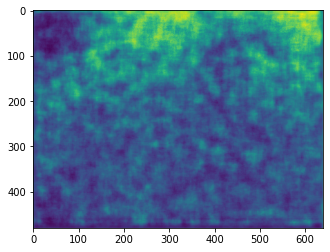

JVisualizer with 1 geometries

In [25]:
model = model.cpu()
model.sample(1)

In [ ]:
model.reconstruct(1)

5892.0


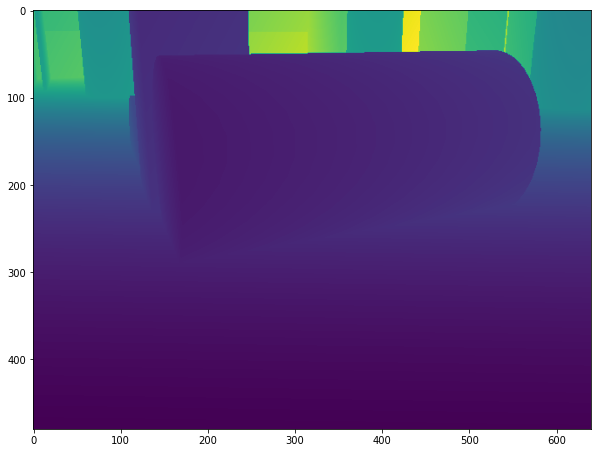

In [27]:
## Plot specific depth image

import cv2

def __getitem__():
        path = "/home/szilard/projects/Disentangled-Variational-Autoencoder/notebook/data/c24s/depth/test/00000.png"
#         path = "/home/szilard/projects/Disentangled-Variational-Autoencoder/samples/version_1_sample0.png"
        depth_input = cv2.imread(path,cv2.IMREAD_UNCHANGED).astype(np.float32)
        print(np.amax(depth_input))
#         depth_input = np.moveaxis(depth_input,-1,0)
        depth_input = torch.from_numpy(depth_input)
        # if self.transform is not None:
        #     img = self.transform(depth_input_mod)
#         target: Any = []

        return depth_input/torch.max(depth_input)#, target

image = __getitem__()
plt.figure(figsize=(10,10))
# print(image.max())
plt.imshow(image)
plt.grid(False)
plt.show()


In [28]:
## Plot specific depth image and its point cloud
import open3d as o3d
import open3d.cpu.pybind.core as o3c
import cv2
from open3d import JVisualizer
def __getitem__():
        path = "/home/szilard/projects/Disentangled-Variational-Autoencoder/notebook/data/c24s/depth/test/00000.png"
        depth_input = cv2.imread(path,cv2.IMREAD_UNCHANGED).astype(np.uint16)
        return depth_input

image = __getitem__()
depth = o3d.geometry.Image(image)
plt.imshow(depth)
plt.show()
K = [582.62448167737955, 0.0, 313.04475870804731, 0.0, 582.69103270988637, 238.44389626620386, 0.0, 0.0, 1.0]
fx = K[0]
fy = K[4]
cx = K[2]
cy = K[5]
w=640
h=480
intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx,fy, cx, cy)
intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
cam = o3d.camera.PinholeCameraParameters()
cam.intrinsic = intrinsic
cam.extrinsic = np.array([[1., 0., 0., 0.], [0., -1., 0., 0.], [0., 0., -1., 0.], [0., 0., 0., 1.]])
pcd = o3d.geometry.PointCloud()
pcd = o3d.geometry.create_point_cloud_from_depth_image(depth, cam.intrinsic,cam.extrinsic)

# print(np.asarray(pcd.points))

visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

ImportError: generic_type: type "VerbosityLevel" is already registered!